## IST 736 Text Mining project code

###Team Members:
- Anjali Shahi
- Nimisha Kadam
- Ayyappa Bhuma

## Notebook Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import all required modules

import pandas as pd
import numpy as np
import string

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
grid_search = False

## Data Preparation

### Loading Data

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/Text Mining Project/final_labels.csv')

data.head()

,entry_id,link_id,parent_id,entry_utc,subreddit,author,body,image,label_date,week,group,sheet_order,level_1,level_2,level_3,strength,highlight,split
0,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train
1,fgb3bdv,t3_exoxn7,t3_exoxn7,1580658139,badwomensanatomy,Machaeon,This is taking a grain of truth and extrapolat...,NaN,17-02-2020,1,1,"(1, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train
2,fgc6tlu,t3_exoxn7,t3_exoxn7,1580669695,badwomensanatomy,CuniculusVincitOmnia,Honestly my favorite thing about this is that ...,NaN,17-02-2020,1,1,"(1, 2)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test
3,fge6msg,t3_exoxn7,t1_fgc6tlu,1580692566,badwomensanatomy,its331am,Source? Doesnt sound right to me idk,NaN,17-02-2020,1,1,"(1, 2, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test
4,fgawus5,t3_exoxn7,t3_exoxn7,1580656280,badwomensanatomy,JaxDefore,"Damn, I saw a movie in which the old woman bat...",NaN,17-02-2020,1,1,"(1, 3)",Misogynistic,Derogation,Moral_inferiority,Nature of the abuse is Implicit,old woman bathed in the blood if virgins,train


In [ ]:
#Removing columns of no use
data = data[["body","level_1","level_2","level_3"]]

print("shape of data:", data.shape)
data.head()

shape of data: (6567, 4)


,body,level_1,level_2,level_3
0,Do you have the skin of a 80 year old grandma?...,Nonmisogynistic,None_of_the_categories,NaN
1,This is taking a grain of truth and extrapolat...,Nonmisogynistic,None_of_the_categories,NaN
2,Honestly my favorite thing about this is that ...,Nonmisogynistic,None_of_the_categories,NaN
3,Source? Doesnt sound right to me idk,Nonmisogynistic,None_of_the_categories,NaN
4,"Damn, I saw a movie in which the old woman bat...",Misogynistic,Derogation,Moral_inferiority


### Data Cleaning

#### Missing Values

In [ ]:
#checking for missing values
data.columns[data.isnull().any()]

Index(['body', 'level_3'], dtype='object')

In [ ]:
#Dropping rows with missing values in main text column
data = data.dropna(subset=['body'])
print("shape of data:", data.shape)

shape of data: (6555, 4)


#### Basic Text Preprocessing

In [ ]:
#preprocessing text with gensim
#lowercasing, removing punctuations, numbers and removing gensim's stopwords

import gensim

def preprocess(text):
    result = ""
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result += " " + token
    result.strip()        
    return result

data['clean'] = data['body'].apply(preprocess)
data.head()

,body,level_1,level_2,level_3,clean
0,Do you have the skin of a 80 year old grandma?...,Nonmisogynistic,None_of_the_categories,NaN,skin year old grandma worry drink water
1,This is taking a grain of truth and extrapolat...,Nonmisogynistic,None_of_the_categories,NaN,taking grain truth extrapolating insanity sta...
2,Honestly my favorite thing about this is that ...,Nonmisogynistic,None_of_the_categories,NaN,honestly favorite thing feel need cite beauty...
3,Source? Doesnt sound right to me idk,Nonmisogynistic,None_of_the_categories,NaN,source doesnt sound right idk
4,"Damn, I saw a movie in which the old woman bat...",Misogynistic,Derogation,Moral_inferiority,damn saw movie old woman bathed blood virgins...


In [ ]:
#Remove punctuation marks
data["clean"] = data['body'].str.replace('[{}]'.format(string.punctuation), '') 

## Data Exploration

Text(0.5, 1.0, 'Class wise count')

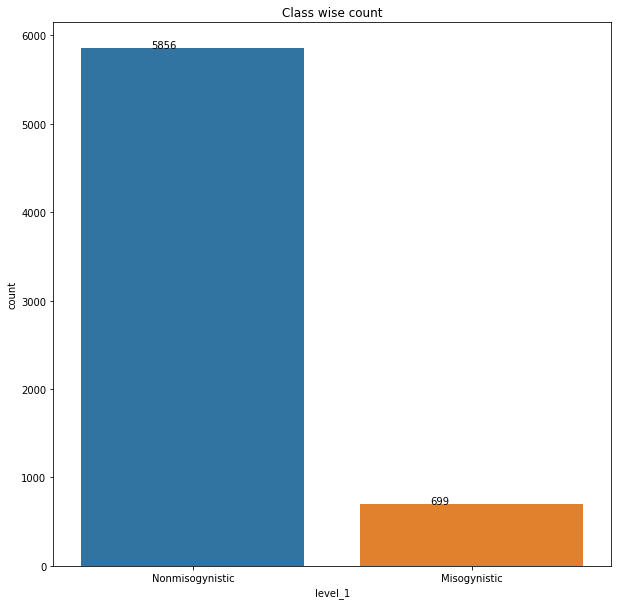

In [ ]:
#target class counts
plt.figure(figsize=(10,10))
ax = sns.countplot(x = data["level_1"],  data = data, order = data["level_1"].value_counts().index )
for p, label in zip(ax.patches, data["level_1"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))
plt.title("Class wise count")

In [ ]:
#Subsetting data based on target class
data_misogynistic = data[data['level_1'] == 'Misogynistic']
data_non_misogynistic = data[data['level_1'] == 'Nonmisogynistic']

In [ ]:
#word dictionaries of each class
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')
cv1 = unigram_tfidf_vectorizer.fit_transform(data_misogynistic['clean'].values.astype('U'))
words1 = np.array(unigram_tfidf_vectorizer.get_feature_names_out())
word_count1 = dict(zip(words1, list(cv1.toarray().sum(axis=0))))

unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')
cv2 = unigram_tfidf_vectorizer.fit_transform(data_non_misogynistic['clean'].values.astype('U'))
words2 = np.array(unigram_tfidf_vectorizer.get_feature_names_out())
word_count2 = dict(zip(words2, list(cv2.toarray().sum(axis=0))))

In [ ]:
#word-cloud to observe the top words in each class
from wordcloud import WordCloud

miso_wordcloud = WordCloud(background_color='white').fit_words(word_count1)
non_miso_wordcloud = WordCloud(background_color='white').fit_words(word_count2)

Text(0.5, 0.74, 'Misogynistic Words:')

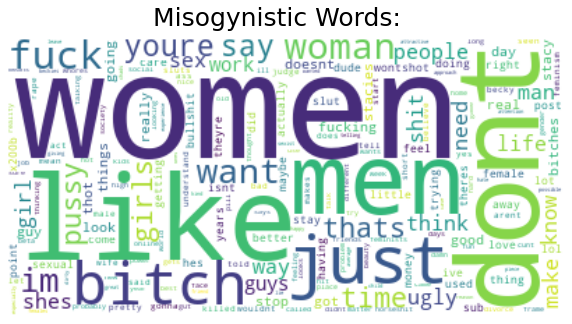

In [ ]:
#plotting word-cloud for misogynistic class
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(miso_wordcloud, interpolation='bilinear')
_ = ax.axis("off")
plt.suptitle("Misogynistic Words:", fontsize=25, y=0.74)

Text(0.5, 0.74, 'Non Misogynistic Words:')

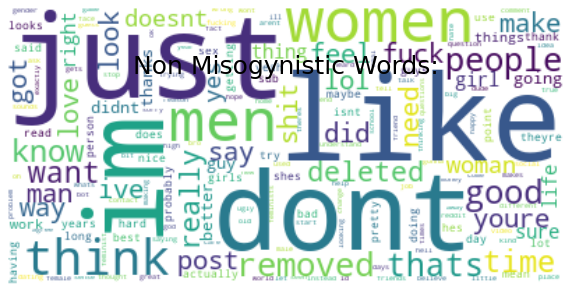

In [ ]:
#plotting word-cloud for non-misogynistic class
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(non_miso_wordcloud, interpolation='bilinear')
_ = ax.axis("off")
plt.title("Non Misogynistic Words:", fontsize=25, y=0.74)

Text(0.5, 1.0, 'Misogynistic Categories')

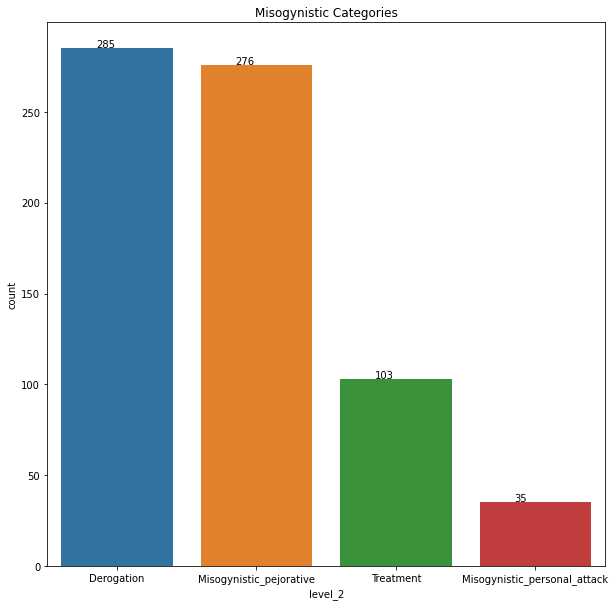

In [ ]:
#misogynistic category counts
plt.figure(figsize=(10,10))
ax = sns.countplot(x = data_misogynistic["level_2"],  data = data_misogynistic, order = data_misogynistic["level_2"].value_counts().index )
for p, label in zip(ax.patches, data_misogynistic["level_2"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))
plt.title("Misogynistic Categories")

### level 3 variable

In [ ]:
#Further dividing the misogynistic sentences based on level 2 variable to observe classes in level 3 variable
misogynistic_derogation = data_misogynistic[data_misogynistic["level_2"] == "Derogation"]
misogynistic_pejorative = data_misogynistic[data_misogynistic["level_2"] == "Misogynistic_pejorative"]
misogynistic_treatment = data_misogynistic[data_misogynistic["level_2"] == "Treatment"]
misogynistic_personal_attack = data_misogynistic[data_misogynistic["level_2"] == "Misogynistic_personal_attack"]

Text(0.5, 1.0, 'Derogation SubCategories')

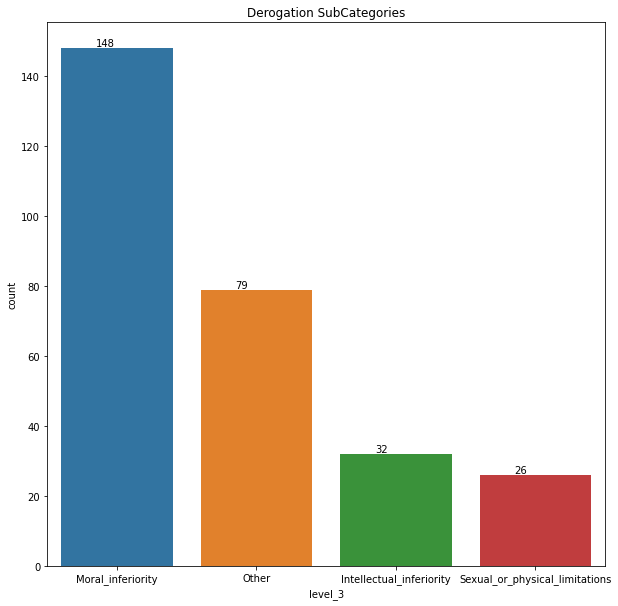

In [ ]:
#misogynistic_derogation
plt.figure(figsize=(10,10))
ax = sns.countplot(x = misogynistic_derogation["level_3"],  data = misogynistic_derogation, order = misogynistic_derogation["level_3"].value_counts().index )
for p, label in zip(ax.patches, misogynistic_derogation["level_3"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))
plt.title("Derogation SubCategories")

Text(0.5, 1.0, 'Treatment SubCategories')

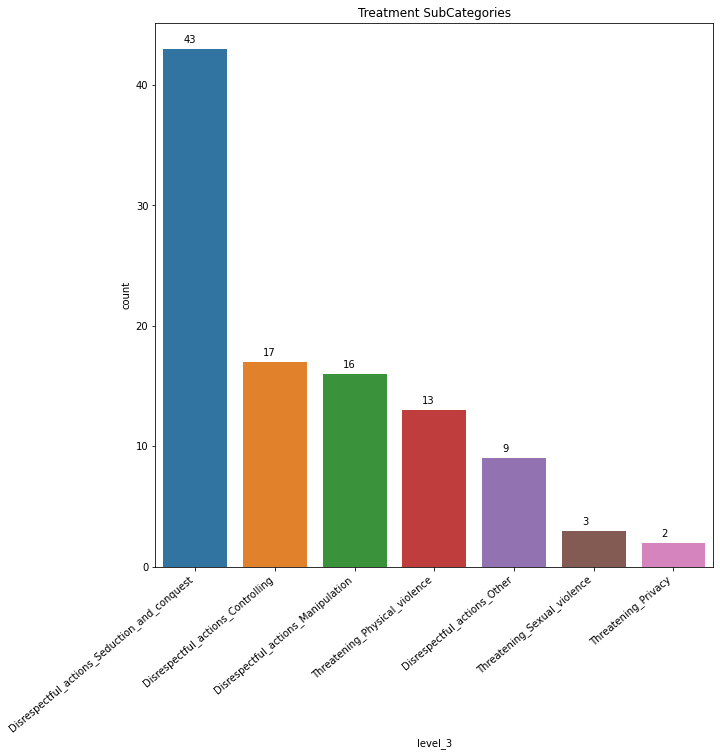

In [ ]:
#misogynistic_treatment
plt.figure(figsize=(10,10))
ax = sns.countplot(x = misogynistic_treatment["level_3"],  data = misogynistic_treatment, order = misogynistic_treatment["level_3"].value_counts().index )
for p, label in zip(ax.patches, misogynistic_treatment["level_3"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Treatment SubCategories")

Text(0.5, 1.0, 'Misogynistic_personal_attack SubCategories')

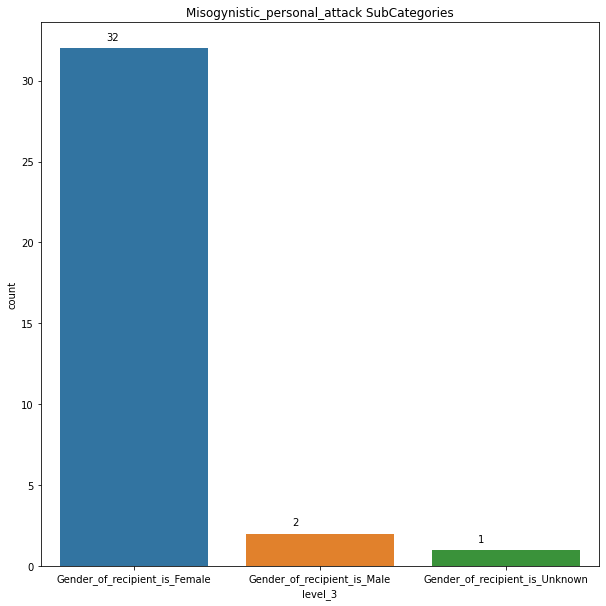

In [ ]:
#misogynistic_personal_attack
plt.figure(figsize=(10,10))
ax = sns.countplot(x = misogynistic_personal_attack["level_3"],  data = misogynistic_personal_attack, order = misogynistic_personal_attack["level_3"].value_counts().index )
for p, label in zip(ax.patches, misogynistic_personal_attack["level_3"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))
plt.title("Misogynistic_personal_attack SubCategories")

## Vectroization

In [ ]:
#  unigram boolean vectorizer, set minimum document frequency to 5
unigram_bool_vectorizer = CountVectorizer(encoding='latin-1', binary=True, min_df=5, stop_words='english')

#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')

#  unigram and bigram term frequency vectorizer, set minimum document frequency to 5
gram12_count_vectorizer = CountVectorizer(encoding='latin-1', ngram_range=(1,2), min_df=5, stop_words='english')

### Comparing vectorizer performances by building a simple linear svc model using different vectorization techniques.

In [ ]:
# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)

#### Train-Test split

In [ ]:
#Train-test split of original dataframe
X_train, X_test, y1_train, y1_test = train_test_split(data['clean'].values, data['level_1'].values, test_size=0.4, random_state=0, stratify = data['level_1'].values)

print(X_train.shape, y1_train.shape, X_test.shape, y1_test.shape)

(3933,) (3933,) (2622,) (2622,)


In [ ]:
#Vectorize train data

#Count Bool vectorizer
# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec_bool = unigram_bool_vectorizer.fit_transform(X_train.astype('U'))
# check the content of a document vector
print(X_train_vec_bool.shape)
print(X_train_vec_bool[0].toarray())

#TFIDF Vectorizer
X_train_vec_tfidf = unigram_tfidf_vectorizer.fit_transform(X_train.astype('U'))
# check the content of a document vector
print(X_train_vec_tfidf.shape)
print(X_train_vec_tfidf[0].toarray())

#Unigram and Bigram count vectorizer
X_train_vec_bigram = gram12_count_vectorizer.fit_transform(X_train.astype('U'))
# check the content of a document vector
print(X_train_vec_bigram.shape)

(3933, 3536)
[[0 0 0 ... 0 0 0]]
(3933, 3536)
[[0. 0. 0. ... 0. 0. 0.]]
(3933, 6623)


In [ ]:
#Vectorize Test Data

X_test_vec_bool = unigram_bool_vectorizer.transform(X_test.astype('U'))

# print out #examples and #features in the test set
print(X_test_vec_bool.shape)

X_test_vec_tfidf = unigram_tfidf_vectorizer.transform(X_test.astype('U'))

# print out #examples and #features in the test set
print(X_test_vec_tfidf.shape)

X_test_vec_bigram = gram12_count_vectorizer.transform(X_test.astype('U'))

# print out #examples and #features in the test set
print(X_test_vec_bigram.shape)


(2622, 3536)
(2622, 3536)
(2622, 6623)


####Count bool vectorizer

Cross-validation score : 0.9105017604779964
Precision: 0.613
Recall: 0.532
Accuracy: 0.914
F1 Score: 0.570


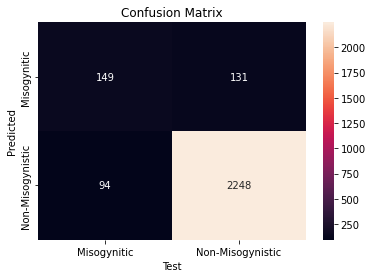

In [ ]:
# use the Count bool vectorized training data to train the MNB model 
svm_clf.fit(X_train_vec_bool,y1_train)

# print confusion matrix (row: ground truth; col: prediction)
y1_pred = svm_clf.fit(X_train_vec_bool, y1_train).predict(X_test_vec_bool)
cm=confusion_matrix(y1_test, y1_pred)

#Cross validation on 5 folds
scores = cross_val_score(svm_clf, X_train_vec_bool, y1_train, cv=5)

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Cross-validation score :',(scores.mean()))

print('Precision: %.3f' % precision_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred,pos_label='Misogynistic'))

####TFIDF vectorizer

Cross-validation score : 0.9300817029916809
Precision: 0.809
Recall: 0.454
Accuracy: 0.930
F1 Score: 0.581


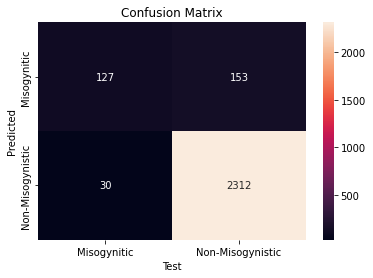

In [ ]:
# use the TFIDF vectorized training data to train the MNB model 
svm_clf.fit(X_train_vec_tfidf,y1_train)

# print confusion matrix (row: ground truth; col: prediction)
y1_pred = svm_clf.fit(X_train_vec_tfidf, y1_train).predict(X_test_vec_tfidf)
cm=confusion_matrix(y1_test, y1_pred)

#Cross validation on 5 folds
scores = cross_val_score(svm_clf, X_train_vec_tfidf, y1_train, cv=5)


fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Cross-validation score :',(scores.mean()))

print('Precision: %.3f' % precision_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred,pos_label='Misogynistic'))

####N-gram vectorizer

Cross-validation score : 0.9097384016993704
Precision: 0.633
Recall: 0.518
Accuracy: 0.916
F1 Score: 0.570


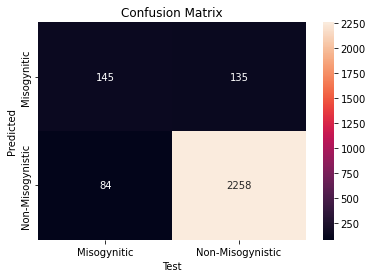

In [ ]:
svm_clf.fit(X_train_vec_bigram,y1_train)

y1_pred = svm_clf.fit(X_train_vec_bigram, y1_train).predict(X_test_vec_bigram)
cm=confusion_matrix(y1_test, y1_pred)

#Cross validation on 5 folds
scores = cross_val_score(svm_clf, X_train_vec_bigram, y1_train, cv=5)
fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Cross-validation score :',(scores.mean()))

print('Precision: %.3f' % precision_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred,pos_label='Misogynistic'))

TF-IDF vectorizer gives the best result (cv score of 92.38%) on the same model. 

#### Top 10 words describing each class

In [ ]:
feature_ranks = sorted(zip(svm_clf.coef_[0], unigram_tfidf_vectorizer.get_feature_names_out()))


#10 features that are least relevant to "positive" sentiment 
positive_10 = feature_ranks[-10:]
print("misogynistic words")
for i in range(0, len(positive_10)):
    print(positive_10[i])
print()

#10 features that are least relevant to "negative" sentiment 
negative_10 = feature_ranks[:10]
print("non-misogynistic words")
for i in range(0, len(negative_10)):
    print(negative_10[i])
print()

misogynistic words
(0.46771541048605886, 'away')
(0.4780103783885485, 'attitude')
(0.4871214941150941, 'bigger')
(0.497537158349725, 'reality')
(0.5139622874377093, 'develop')
(0.530262095445289, 'worrying')
(0.5329116596613773, 'proving')
(0.5432778113350357, 'ltrs')
(0.5527502336332177, 'daughters')
(0.6596440695886692, 'personal')

non-misogynistic words
(-1.8256958673283428, 'communicate')
(-1.4626584683679815, 'compete')
(-1.4444695544607786, 'forum')
(-1.3458348686225803, 'successfully')
(-1.2831728239727478, 'jockey')
(-1.2725467472270096, 'arent')
(-1.2667313035024295, 'oh')
(-1.0627668420397773, 'chat')
(-0.9190113378148798, 'illegal')
(-0.8268381153902129, 'sexier')



## Sampling

#### SMOTE Analysis

Cross-validation score : 0.9300817029916809
Precision: 0.257
Recall: 0.639
Accuracy: 0.764
F1 Score: 0.367


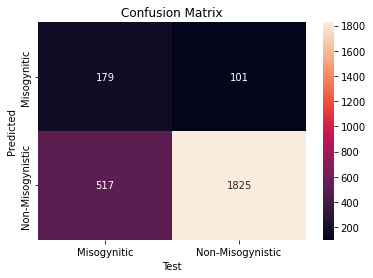

In [ ]:
#Sampling with SMOTE analysis
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
smt = SMOTE(random_state=0)

textclassifier =Pipeline([
   ('tfidf', TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')),
   ('smote', SMOTE(random_state=0)),
   ('svc', LinearSVC(C =1))
])


y1_pred_sample =  textclassifier.fit(X_train.astype('U'), y1_train).predict(X_test.astype('U'))
cm=confusion_matrix(y1_test, y1_pred_sample)

#Cross validation on 5 folds
scores = cross_val_score(svm_clf, X_train_vec_tfidf, y1_train, cv=5)


fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Cross-validation score :',(scores.mean()))

print('Precision: %.3f' % precision_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred_sample))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))


#### Random Under-sampling

Precision: 0.319
Recall: 0.743
Accuracy: 0.803
F1 Score: 0.446


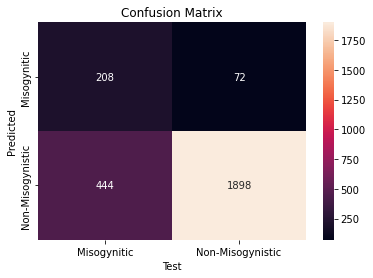

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

rus = RandomUnderSampler(random_state=0)

textclassifier =Pipeline([
   ('tfidf', TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')),
   ('rus', RandomUnderSampler(random_state=0)),
   ('svc', LinearSVC(C =1))
])


y1_pred_sample =  textclassifier.fit(X_train.astype('U'), y1_train).predict(X_test.astype('U'))
cm=confusion_matrix(y1_test, y1_pred_sample)

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Precision: %.3f' % precision_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred_sample))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))

#### Random Over-sampling

Precision: 0.518
Recall: 0.564
Accuracy: 0.897
F1 Score: 0.540


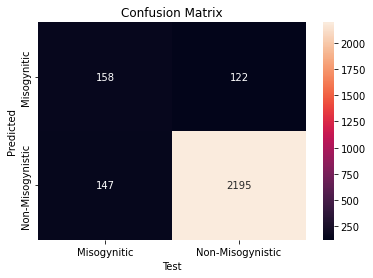

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

ros = RandomOverSampler(random_state=0)

textclassifier =Pipeline([
   ('tfidf', TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')),
   ('ros', RandomOverSampler(random_state=0)),
   ('svc', LinearSVC(C =1))
])


y1_pred_sample =  textclassifier.fit(X_train.astype('U'), y1_train).predict(X_test.astype('U'))
cm=confusion_matrix(y1_test, y1_pred_sample)

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Test');ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

print('Precision: %.3f' % precision_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))
print('Accuracy: %.3f' % accuracy_score(y1_test, y1_pred_sample))
print('F1 Score: %.3f' % f1_score(y1_test, y1_pred_sample,pos_label='Misogynistic'))

#### Final Sampling

On analysing the 3 different samplings, random under-sampling worked better

In [ ]:
#random under sampling of data
data_sampled = data.groupby('level_1').apply(lambda x: x.sample(699, random_state=0, replace=False))

data_sampled = shuffle(data_sampled).reset_index(drop=True) # Shuffle
print("shape of sampled data", data_sampled.shape)
data_sampled.head()

shape of sampled data (1398, 5)


,body,level_1,level_2,level_3,clean
0,"You notice it more after reading trp, that doe...",Nonmisogynistic,None_of_the_categories,NaN,You notice it more after reading trp that does...
1,"Girls want sex too, youre the one that messes ...",Misogynistic,Misogynistic_pejorative,NaN,Girls want sex too youre the one that messes i...
2,"Most normies don't find love. Sure, normies ha...",Nonmisogynistic,None_of_the_categories,NaN,Most normies dont find love Sure normies have ...
3,"My MGTOW story..Hello, my friends.\n\nGrew up ...",Misogynistic,Derogation,Intellectual_inferiority,My MGTOW storyHello my friends\n\nGrew up in a...
4,Why do so many women tolerate and even encoura...,Nonmisogynistic,None_of_the_categories,NaN,Why do so many women tolerate and even encoura...


## Data Modelling

#### Train test split

In [ ]:
#Train-test split of original dataframe
X_train, X_test, y1_train, y1_test = train_test_split(data['clean'].values, data['level_1'].values, test_size=0.4, random_state=0, stratify = data['level_1'].values)

print(X_train.shape, y1_train.shape, X_test.shape, y1_test.shape)

(3933,) (3933,) (2622,) (2622,)


In [ ]:
#Train-test split of sampled dataframe
X_sampled_train, X_sampled_test, y1_sampled_train, y1_sampled_test = train_test_split(data_sampled['clean'].values, data_sampled['level_1'].values, test_size=0.3, random_state=0, stratify=data_sampled['level_1'].values)

print(X_sampled_train.shape, y1_sampled_train.shape, X_sampled_test.shape, y1_sampled_test.shape)

(978,) (978,) (420,) (420,)


### Level 1 Classification : BERT model

#### Loading BERT uncased model with sklearn wrapper

In [ ]:
# !pip3 uninstall urllib3
# !pip3 install urllib3

In [ ]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .

from bert_sklearn import BertClassifier

fatal: destination path 'bert-sklearn' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/bert-sklearn
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-py3-none-any.whl size=54247 sha256=60570e20e06bf3fac7eaafce8e643f2d7696b17f1c7b16aecfdda39f784662d0
  Stored in directory: /root/.cache/pip/wheels/8d/e4/93/8fd41f4e63d46a653c0e0a2da9e71c75614c66cb00c6100556
Successfully built bert-sklearn
  Attempting uninstall: bert-sklearn
    Found existing installation: bert-sklearn 0.3

####BERT model without sampling

In [ ]:
model1 = BertClassifier()         
print(model1)
model1.fit(X_train, y1_train)

Building sklearn text classifier...
BertClassifier()
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 3540, validation data size: 393



Training  :   0%|          | 0/111 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.3738, Val loss: 0.4150, Val accy: 80.92%



Training  :   0%|          | 0/111 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.2656, Val loss: 0.2534, Val accy: 90.33%



Training  :   0%|          | 0/111 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.1702, Val loss: 0.2476, Val accy: 91.35%



BertClassifier(do_lower_case=True,
               label_list=array(['Misogynistic', 'Nonmisogynistic'], dtype=object))

In [ ]:
# testing unsampled model
# test accuracy
bert_acc = model1.score(X_test, y1_test)
print(bert_acc)

# test f1_score
y_pred = model1.predict(X_test)
bert_f1 = f1_score(y1_test, y_pred, average = None)
bert_f1_macro = f1_score(y1_test, y_pred, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/328 [00:00<?, ?it/s]


Loss: 0.2180, Accuracy: 92.94%
92.9443173150267


Predicting:   0%|          | 0/328 [00:00<?, ?it/s]

[0.58797327 0.96141814]
0.7746957089209946


####BERT model with sampling

In [ ]:
model2 = BertClassifier()         
print(model2)
model2.fit(X_sampled_train, y1_sampled_train)

Building sklearn text classifier...
BertClassifier()
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 881, validation data size: 97



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.6438, Val loss: 0.6225, Val accy: 72.16%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.3906, Val loss: 0.5551, Val accy: 75.26%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.2189, Val loss: 0.6180, Val accy: 78.35%



BertClassifier(do_lower_case=True,
               label_list=array(['Misogynistic', 'Nonmisogynistic'], dtype=object))

In [ ]:
#model2 performance on sampled test data
# test accuracy
bert_acc = model2.score(X_sampled_test, y1_sampled_test)
print(bert_acc)

# test f1_score
y_pred = model2.predict(X_sampled_test)
bert_f1 = f1_score(y1_sampled_test, y_pred, average = None)
bert_f1_macro = f1_score(y1_sampled_test, y_pred, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/53 [00:00<?, ?it/s]


Loss: 0.4261, Accuracy: 81.43%
81.42857142857143


Predicting:   0%|          | 0/53 [00:00<?, ?it/s]

[0.82110092 0.80693069]
0.8140158052502499


In [ ]:
#model2 performance on original biased test data
# test accuracy
bert_acc = model2.score(X_test, y1_test)
print(bert_acc)

# test f1_score
y_pred = model2.predict(X_test)
bert_f1 = f1_score(y1_test, y_pred, average = None)
bert_f1_macro = f1_score(y1_test, y_pred, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/328 [00:00<?, ?it/s]


Loss: 0.4137, Accuracy: 82.00%
81.99847444698703


Predicting:   0%|          | 0/328 [00:00<?, ?it/s]

[0.52226721 0.88909774]
0.7056824754193174


#### Grid - search to find optimal epochs and learning rate

In [ ]:
#grid search to decide on epochs and learning rate
if grid_search == True:
  params = {'epochs':[4, 5, 6], 'learning_rate':[2e-5, 3e-5, 5e-5]}

  # wrap classifier in GridSearchCV
  clf = GridSearchCV(BertClassifier(validation_fraction=0), 
                      params,
                      scoring='accuracy',
                      verbose=True)

  # fit gridsearch 
  clf.fit(X_sampled_train ,y1_sampled_train)

In [ ]:
#grid search result
if grid_search == True:
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']

  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
          print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))
          
  # best scores
  print("\nBest score:", clf.best_score_,"with params:", clf.best_params_)

Based on grid search optimal epochs = 6 and optimal learning rate = 3e-5

#### Optimal BERT model

In [ ]:
#training best BERT model
model_best = BertClassifier(epochs=6, learning_rate=3e-05)         
print(model_best)
model_best.fit(X_sampled_train, y1_sampled_train)

Building sklearn text classifier...
BertClassifier(epochs=6, learning_rate=3e-05)
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 881, validation data size: 97



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.6550, Val loss: 0.6293, Val accy: 73.20%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.3938, Val loss: 0.5331, Val accy: 74.23%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.2055, Val loss: 0.8102, Val accy: 77.32%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4, Train loss: 0.0791, Val loss: 1.1627, Val accy: 77.32%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5, Train loss: 0.0168, Val loss: 1.1349, Val accy: 77.32%



Training  :   0%|          | 0/28 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6, Train loss: 0.0069, Val loss: 1.1822, Val accy: 77.32%



BertClassifier(do_lower_case=True, epochs=6,
               label_list=array(['Misogynistic', 'Nonmisogynistic'], dtype=object),
               learning_rate=3e-05)

In [ ]:
#best model performance on sampled test data
# test accuracy
bert_acc = model_best.score(X_sampled_test, y1_sampled_test)
print(bert_acc)

# test f1_score
y_pred = model_best.predict(X_sampled_test)
bert_f1 = f1_score(y1_sampled_test, y_pred, average = None)
bert_f1_macro = f1_score(y1_sampled_test, y_pred, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/53 [00:00<?, ?it/s]


Loss: 0.7364, Accuracy: 80.71%
80.71428571428572


Predicting:   0%|          | 0/53 [00:00<?, ?it/s]

[0.8057554  0.80851064]
0.8071330169906628


In [ ]:
#best model performance on biased test data
# test accuracy
bert_acc = model_best.score(X_test, y1_test)
print(bert_acc)

# test f1_score
y_pred = model_best.predict(X_test)
bert_f1 = f1_score(y1_test, y_pred, average = None)
bert_f1_macro = f1_score(y1_test, y_pred, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/328 [00:00<?, ?it/s]


Loss: 0.5122, Accuracy: 84.36%
84.3630816170862


Predicting:   0%|          | 0/328 [00:00<?, ?it/s]

[0.55434783 0.90518039]
0.7297641073080481


In [ ]:
#Precision-recall scores of the best BERT model
print('Precision: %.3f' % precision_score(y1_test, y_pred, pos_label='Misogynistic'))
print('Recall: %.3f' % recall_score(y1_test, y_pred, pos_label='Misogynistic'))
print('F1 Score: %.3f' % f1_score(y1_test, y_pred, pos_label='Misogynistic'))

print('\n')

print('Precision_macro: %.3f' % precision_score(y1_test, y_pred, average = 'macro'))
print('Recall_macro: %.3f' % recall_score(y1_test, y_pred, average = 'macro'))
print('F1 Score_macro: %.3f' % f1_score(y1_test, y_pred, average = 'macro'))

Precision: 0.398
Recall: 0.911
F1 Score: 0.554


Precision_macro: 0.693
Recall_macro: 0.873
F1 Score_macro: 0.730


[Text(0, 0.5, 'Misogynitic'), Text(0, 1.5, 'Non-Misogynistic')]

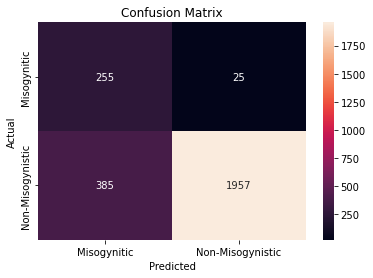

In [ ]:
cm=confusion_matrix(y1_test, y_pred)

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])
ax.yaxis.set_ticklabels(['Misogynitic','Non-Misogynistic'])

#### Error Analysis

In [ ]:
# BERT error analysis
err_cnt = 0
for i in range(0, len(y1_test)):
  if (y1_test[i]=='Misogynistic' and y_pred[i]=='Nonmisogynistic'):
    print(X_test[i])
    err_cnt = err_cnt+1
print("errors:", err_cnt)

We have ourselves a heffer
Lack of romance and intimacy is NOT my biggest issue with inceldomIts bullying It still occurs to me at the age of 21 in medical university People in general associate bullying with middle school when kids undergo puberty but it still continues for me 

I wish that my only problem with ugliness was the lack of success with women I found many copes like vidya movies and dog to cope with loneliness Its painful to be alone but its possible to go on 

But bullying absolutely destroys my mentality and will to live It happens almost weekly Ive developed social anxiety and depression I cannot go outside feeling safe I have missed all my lectures in the past 3 months and when I did go outside I was met with more bullying I cannot do my favorite sport I cant even go shopping because I will be met with smirks and looks of disgust This is the life of ugly man 

Who are the bullies Its mostly women  educated medical students that will soon become doctors What do they say

In [ ]:
# BERT error analysis
err_cnt = 0
for i in range(0, len(y1_test)):
  if (y1_test[i]=='Nonmisogynistic' and y_pred[i]=='Misogynistic'):
    print(X_test[i])
    err_cnt = err_cnt+1
print("errors:", err_cnt)

This not an ig model Shes a porn star Shes very successful She lives in LA Ive been following her on all her platforms for awhile She does alot of cam modeling and she also has her own website
Nah not quite Won just short of 2 million in 96 yeah 1996 didnt tell a soul pressed for divorce didnt disclose it as an asset  not even to her own counsel She was found out when the court was going through everything in 99 Judge gave her winnings to the husband
A couple of responses then a larger thought 

Feminists dont agree on every point regarding gender disparities Pasquerella for example is not troubled by the lopsided overrepresentation of women in nursing she said because there is no evidence men face stigma or discrimination in that field

I find that hard to believe I mean its anecdotal to be sure but I have friends and relatives that have gone through nursing programs and this wasnt their experience at all It was actually akin to the worst stories that you hear about women in other cou

### Level 2 Classification : BERT Model

#### Train-Test split

In [ ]:
X_train2, X_test2, y2_train, y2_test = train_test_split(data_misogynistic['clean'].values, data_misogynistic['level_2'].values, test_size=0.2, random_state=0, stratify = data_misogynistic['level_2'].values)


print('Level 2')
print(X_train2.shape, y2_train.shape, X_test2.shape, y2_test.shape)


Level 2
(559,) (559,) (140,) (140,)


In [ ]:
#training best BERT model
model_best = BertClassifier(epochs = 6)         
print(model_best)
model_best.fit(X_train2, y2_train)

Building sklearn text classifier...
BertClassifier(epochs=6)
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 504, validation data size: 55



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1, Train loss: 1.2320, Val loss: 1.0349, Val accy: 63.64%



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 2, Train loss: 1.0229, Val loss: 0.9179, Val accy: 61.82%



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.7936, Val loss: 0.9018, Val accy: 60.00%



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 4, Train loss: 0.5530, Val loss: 1.0500, Val accy: 61.82%



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 5, Train loss: 0.3958, Val loss: 1.0044, Val accy: 60.00%



Training  :   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 6, Train loss: 0.3428, Val loss: 1.0242, Val accy: 60.00%



BertClassifier(do_lower_case=True, epochs=6,
               label_list=array(['Derogation', 'Misogynistic_pejorative',
       'Misogynistic_personal_attack', 'Treatment'], dtype=object))

In [ ]:
#best model performance on  test data
# test accuracy
bert_acc = model_best.score(X_test2, y2_test)
print(bert_acc)

# test f1_score
y_pred2 = model_best.predict(X_test2)
bert_f1 = f1_score(y2_test, y_pred2, average = None)
bert_f1_macro = f1_score(y2_test, y_pred2, average = 'macro')

print(bert_f1)
print(bert_f1_macro)

Testing:   0%|          | 0/18 [00:00<?, ?it/s]


Loss: 1.2053, Accuracy: 58.57%
58.57142857142858


Predicting:   0%|          | 0/18 [00:00<?, ?it/s]

[0.69354839 0.59459459 0.         0.33333333]
0.4053690787561755


[Text(0, 0.5, 'Derogation'),
 Text(0, 1.5, 'Misogynistic_pejorative'),
 Text(0, 2.5, 'Treatment'),
 Text(0, 3.5, 'Misogynistic_personal_attack')]

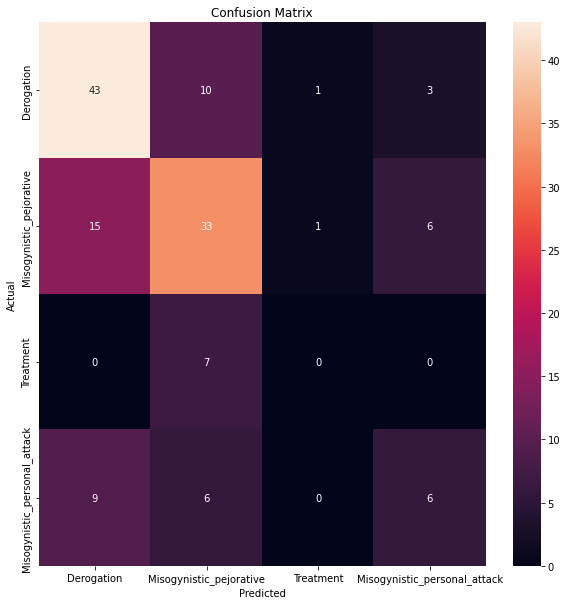

In [ ]:
cm=confusion_matrix(y2_test, y_pred2)

fig = plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Derogation','Misogynistic_pejorative', 'Treatment', 'Misogynistic_personal_attack'])
ax.yaxis.set_ticklabels(['Derogation','Misogynistic_pejorative', 'Treatment', 'Misogynistic_personal_attack'])

#### Error analysis

In [ ]:
#BERT error analysis
err_cnt = 0
for i in range(0, len(y2_test)):
  if (y2_test[i]=='Derogation' and y_pred2[i]=='Misogynistic_pejorative'):
    print(X_test2[i])
    err_cnt = err_cnt+1
print("errors:", err_cnt)

Sounds like bullshit  Women are programmed to know they can get more  Thats why once you start hitting on a 45 she turns into the biggest slut because you made her realize someone wants to fuck her so others will want to as well  

Shes is playing you for a sucker
Aye even here these dolts still see us as possessions

\walkaway
Theres no way he would want to have sex with those ugly ghetto whoresOne of them claimed her assailant was a short black man which Holtzclaw obviously isntThe only DNA was from convicted criminal Adaira Gardner who told her mom she wanted to go out with Holtzclaw because he was a hot cop The case is a fucking fraud
If shes banged more than 6 dudes or so she will NEVER pair bond with you
rpussypassdenied
Ive noticed this with gamers Male games who go outside love to talk about their favourite games dont focus on what they hate and love to encourage people no matter what gender to play their fave games Like the average person with a favourite tv show Guys who spea

In [ ]:
#BERT error analysis
err_cnt = 0
for i in range(0, len(y2_test)):
  if (y2_test[i]=='Nonmisogynistic' and y_pred2[i]=='Misogynistic'):
    print(X_test2[i])
    err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 0


### Level 3 : Topic Modelling

#### LDA

In [ ]:
#TFIDF Vectorizer
data_misogynistic = data[data['level_1'] == 'Misogynistic']

X_train_vec_tfidf = unigram_tfidf_vectorizer.fit_transform(data_misogynistic['clean'].values.astype('U'))

tfidf_feature_names = unigram_tfidf_vectorizer.get_feature_names_out()
print(len(unigram_tfidf_vectorizer.vocabulary_))

2404


In [ ]:
# call the LDA algorithm to fit a topic model, and transform all documents to their topic distrinbutions

from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 11

# Run NMF
#nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(X_train_vec_tfidf)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [ ]:
#Examining the topic clusters

display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0:
thot smart prostitute paid difference whats believes isnt females attentive
Topic 1:
rape law accusations porn false divorce attractive makes doesnt age
Topic 2:
stacy beauty eye model equality women said wow feminism men
Topic 3:
pussy mods ya women making pass hoe hit stfu lol
Topic 4:
short sweet afford somebody damn job dude becky used wtf
Topic 5:
karens fair let want dont women woke thats gender wait
Topic 6:
women like bitch men dont just fuck woman want im
Topic 7:
moms baby chads raise want dont dirty skank bitch complain
Topic 8:
definitely gold gotta dig women nice vet sluts cultural ladies
Topic 9:
cunt shock stupid freedom stacies mans womans feminism sacrifice em
Topic 10:
men women just bitches fuck feminists ugly sex way like


topic 3 - dehumanisation and overt topic topic 8 - immutable gendered stereotypes topic 6 - descriptive attacks/ emotive attacks/ gendered slurs topic 7 - casual use of genedered slurs topic 0 - immutable gendered stereotypes/ casual use of slurs

topic 10 - causal use of gendered slurs topic 4& 5 - mistreatment of individual women

topic 2 - unknown/ backhanded gendered compliments

topic 1 - incitement and encouragement of harm

#### BERT topic modelling

In [ ]:
# !pip install bertopic
# !pip install --upgrade joblib==1.1.0

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(embedding_model="all-MiniLM-L12-v2", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(data_misogynistic['clean'].tolist())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

2022-12-13 23:50:41,542 - BERTopic - Transformed documents to Embeddings
2022-12-13 23:50:53,049 - BERTopic - Reduced dimensionality
2022-12-13 23:50:53,132 - BERTopic - Clustered reduced embeddings


In [ ]:
#visualizing tpoic modelling results

topic_model.visualize_barchart(top_n_topics=11)